In [1]:
import wandb
wandb.login()

wandb: Currently logged in as: huailegedan (upc-lbw). Use `wandb login --relogin` to force relogin


True

In [2]:
from lightning.pytorch.loggers import WandbLogger
logger = WandbLogger(project="rl4co", name="luop-ama2c150Mix")

In [3]:
from rl4co.envs import landuseOptEnv
import torch
from rl4co.models import AttentionModel, AttentionModelPolicy
from rl4co.models.nn.env_embeddings.context import LOPContext
from rl4co.models.nn.env_embeddings.dynamic import StaticEmbedding
from rl4co.models.nn.env_embeddings.init import lopInitEmbedding
from rl4co.utils import RL4COTrainer
from rl4co.utils.decoding import random_policy, rollout

In [4]:
from rl4co.envs.common.distribution_utils import Mix_Distribution
from rl4co.models.rl.a2c.a2c import A2C
from rl4co.models.zoo.polynet.policy import PolyNetPolicy
from rl4co.models import PPO, AMPPO, POMO, PointerNetwork, PointerNetworkPolicy, PolyNet

batch_size = 1024
loc_sampler = Mix_Distribution(n_cluster=3)
env = landuseOptEnv(generator_params=dict(num_loc=150, loc_sampler=loc_sampler))
emb_dim = 128
# policy = PolyNetPolicy(env_name=env.name, # this is actually not needed since we are initializing the embeddings!
#                               embed_dim=emb_dim,
#                               k=5,
#                               init_embedding=lopInitEmbedding(emb_dim),
#                               context_embedding=LOPContext(emb_dim),
#                               dynamic_embedding=StaticEmbedding(emb_dim)
# )
policy = AttentionModelPolicy(env_name=env.name, # this is actually not needed since we are initializing the embeddings!
                              embed_dim=emb_dim,
                              init_embedding=lopInitEmbedding(emb_dim),
                              context_embedding=LOPContext(emb_dim),
                              dynamic_embedding=StaticEmbedding(emb_dim)
)
# Model: default is AM with REINFORCE and greedy rollout baseline
model = A2C(env,
           policy=policy,
           batch_size=1024,
           val_batch_size= 1024,
           test_batch_size= 1024,
           train_data_size=1_000_000, # really small size for demo
           val_data_size=10_000,
           test_data_size=10_000,
           optimizer_kwargs={
               "lr":1e-4,
               "weight_decay": 1e-6,
           },
           lr_scheduler="MultiStepLR",
           lr_scheduler_kwargs={
                "milestones": [100, 120, 140],
                "gamma":0.1,
           },
           )


D:\Anaconda\envs\rl4co\lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'env' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['env'])`.
D:\Anaconda\envs\rl4co\lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'policy' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['policy'])`.
D:\Anaconda\envs\rl4co\lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'baseline' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['baseline'])`.
D:\Anaconda\envs\rl4co\lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'critic' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them 

D:\DRLtest\rl4co_tensor\rl4co\rl4co\models\nn\attention.py:128: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  out = self.sdpa_fn(
D:\DRLtest\rl4co_tensor\rl4co\rl4co\envs\urbanplan\cityplan\env.py:218: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  neighbors = torch.tensor(neighbors, dtype=torch.long, device=device)  # Shape: [batch_size, num_centers, num_neighbours + 1]


Problem 1 | Cost: -1.301


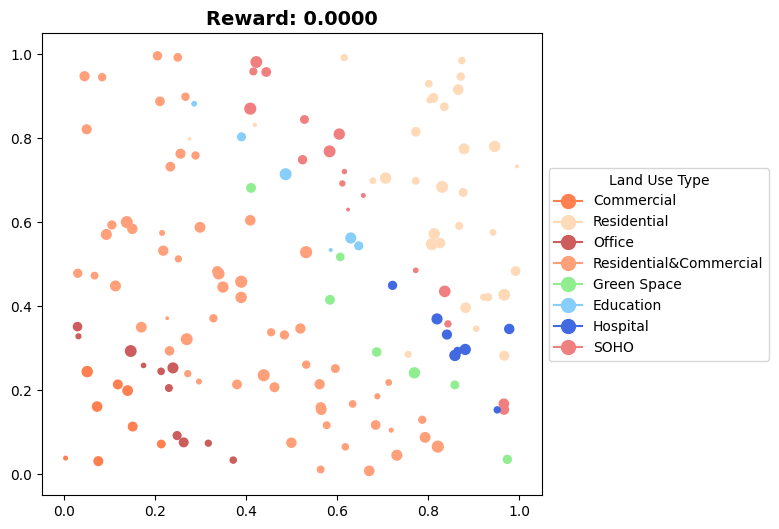

Problem 2 | Cost: -1.934


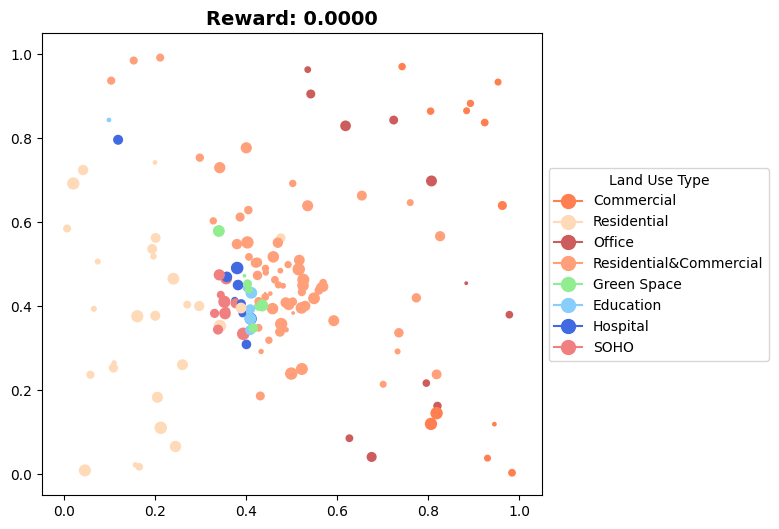

Problem 3 | Cost: -1.235


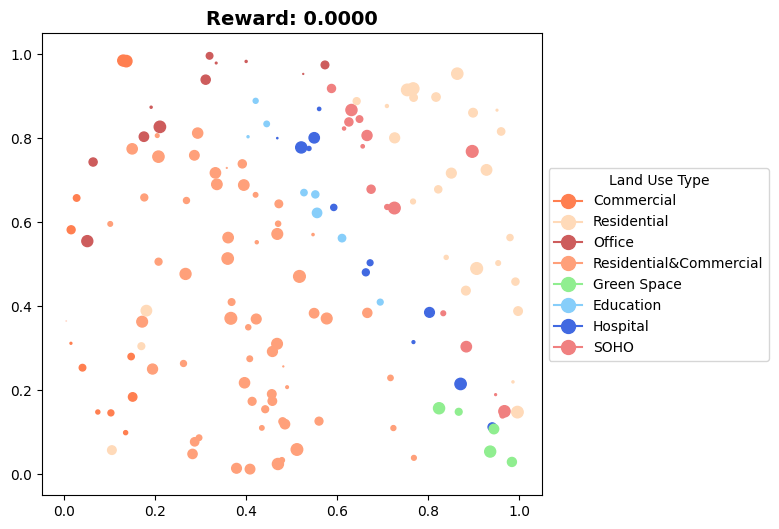

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
td_init = env.reset(batch_size=[3]).to(device)
policy = model.policy.to(device)
out = policy(td_init.clone(), env, phase="test", decode_type="greedy", return_actions=True)

actions_untrained = out['actions'].cpu().detach()
rewards_untrained = out['reward'].cpu().detach()

for i in range(3):
    print(f"Problem {i+1} | Cost: {-rewards_untrained[i]:.3f}")
    env.render(td_init[i], actions_untrained[i])

In [6]:
from lightning.pytorch.callbacks import ModelCheckpoint, RichModelSummary
# Checkpointing callback: save models when validation reward improves
checkpoint_callback = ModelCheckpoint(  dirpath="checkpoints150a2cMix", # save to checkpoints/
                                        filename="epoch_{epoch:03d}",  # save as epoch_XXX.ckpt
                                        save_top_k=2, # save only the best model
                                        save_last=True, # save the last model
                                        monitor="val/reward", # monitor validation reward
                                        mode="max") # maximize validation reward

# Print model summary
rich_model_summary = RichModelSummary(max_depth=3)
# Callbacks list
callbacks = [checkpoint_callback, rich_model_summary]

In [7]:
from rl4co.utils.trainer import RL4COTrainer

trainer = RL4COTrainer(
    max_epochs=150,
    accelerator="gpu",
    devices=1,
    logger=logger,
    callbacks=callbacks,
)

Using 16bit Automatic Mixed Precision (AMP)
Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.rich_model_summary.RichModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [8]:
trainer.fit(model)

D:\Anaconda\envs\rl4co\lib\site-packages\wandb\sdk\lib\ipython.py:89: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display


val_file not set. Generating dataset instead
test_file not set. Generating dataset instead
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃    ┃ Name                                   ┃ Type                  ┃ Params ┃ Mode  ┃
┡━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0  │ env                                    │ landuseOptEnv         │      0 │ train │
│ 1  │ policy                                 │ AttentionModelPolicy  │  694 K │ train │
│ 2  │ policy.encoder                         │ AttentionModelEncoder │  595 K │ train │
│ 3  │ policy.encoder.init_embedding          │ lopInitEmbedding      │    512 │ train │
│ 4  │ policy.encoder.net                     │ GraphAttentionNetwork │  594 K │ train │
│ 5  │ policy.decoder                         │ AttentionModelDecoder │ 99.3 K │ train │
│ 6  │ policy.decoder.context_embedding       │ LOPContext            │ 17.4 K │ train │
│ 7  │ policy.decoder.dynamic_embedding       │ StaticEmbedding       │      0 │ train │
│ 8  │ policy.decoder.pointer                 │ PointerAttention      │ 16.4 K │ train │
│ 9  │ policy.decoder.project_node_embeddings │ Linear                │ 49.2 K │ train │
│ 10 │ policy.decoder.project_fixed_context   │ Linear                │ 16.4 K │ train │
│ 11 │ baseline                               │ CriticBaseline        │  661 K │ train │
│ 12 │ baseline.critic                        │ CriticNetwork         │  661 K │ train │
│ 13 │ baseline.critic.encoder                │ AttentionModelEncoder │  595 K │ train │
│ 14 │ baseline.critic.value_head             │ Sequential            │ 66.6 K │ train │
└────┴────────────────────────────────────────┴───────────────────────┴────────┴───────┘

Trainable params: 1.4 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 1.4 M                                                                                                
Total estimated model params size (MB): 5

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

D:\Anaconda\envs\rl4co\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
D:\Anaconda\envs\rl4co\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=150` reached.


Tour lengths: ['-1.40', '-2.28', '-1.61']


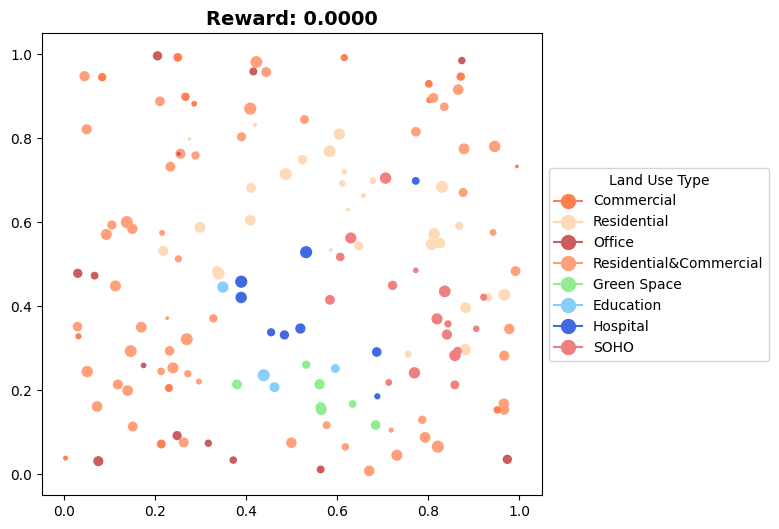

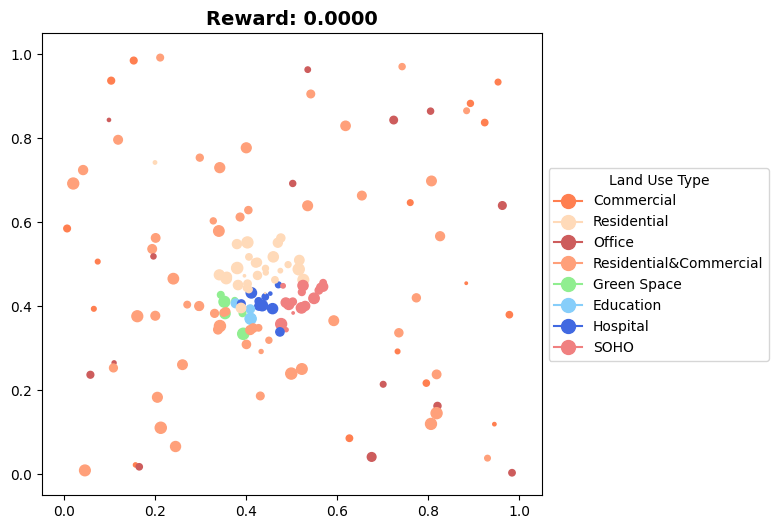

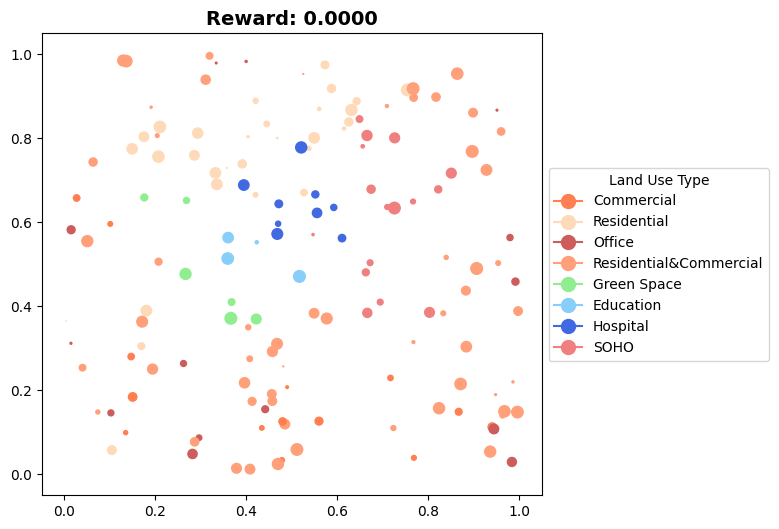

In [9]:
# Greedy rollouts over trained model (same states as previous plot)
policy = model.policy.to(device)
out = policy(td_init.clone(), env, phase="test", decode_type="greedy", return_actions=True)

# Plotting
print(f"Tour lengths: {[f'{-r.item():.2f}' for r in out['reward']]}")
for td, actions in zip(td_init, out['actions'].cpu()):
    env.render(td, actions)

In [10]:
trainer.save_checkpoint("./Trained/LUOP200_100_finish.ckpt")